## Table of Contents:
1. [Problem Description](#problem-description)
2. [Second Bullet Header](#second-bullet)

In [1]:
import pypsa
import random
import pandas as pd
import matplotlib.pyplot as plt

## 1. Problem Description <a class="anchor" id="problem-description"></a>

In this example, we are going to build a super simple illustrative power model for Singapore (SGP) using PyPSA. 

This notebook will help you to:

1. Understand how to make PyPSA models.
2. Understand the components of the PyPSA framework.

Our super simple model for SGP is illustrated below. As we can see, we are imagining that SGP's power generation system is made up of a single fossil (gas) power plant and a solar farm. The outpot from these two plants is pooled in the local balancing zone and distributed to the whole country. Clearly, this is just an illustrative model and the real-world system is far more complex. However, these types of "lumped flow models" can be quite useful to a modeller/analyst when testing out scenarios and methodologies. 

<div>
<img src="../img/toy_model_sgp.png" width="500"/>
</div>


## Model build

### Step 1: Setup global variables and params

In [2]:
# define singapore data
sgp = {
    # iso code
    'iso'   : 'SGP',
    # full name
    'name'  : 'Singapore',
    # longitude
    'x'     : 103.851959,
    # latitude
    'y'     : 1.290270,
}

# define temporal resolution: let's do a 24 hour simulation
timesteps = 24

In [3]:
# build a synthetic demand for 24 hours
demand = \
    pd.DataFrame({
        'snapshot' : pd.date_range("2023-01-01", periods=timesteps, freq="H"),
        'unit' : 'MWh',
        'singapore' : random.sample(range(100, 500), timesteps),
    }).set_index('snapshot')

demand.head(5)

,unit,singapore
snapshot,,
2023-01-01 00:00:00,MWh,283
2023-01-01 01:00:00,MWh,222
2023-01-01 02:00:00,MWh,264
2023-01-01 03:00:00,MWh,383
2023-01-01 04:00:00,MWh,243


In [4]:
# load solar profile
#   - We are using a hypothetical profile downloaded from renewables ninja (https://www.renewables.ninja/)
#   - This curve tells us how much electricity we can generate (MWh) from a 1 MW solar farm

res_profiles = \
    pd.DataFrame({
        'snapshot' : pd.date_range("2023-01-01", periods=timesteps, freq="H"),
        'unit' : 'CF',
        'solar' : pd.read_csv('../data/ninja_pv_1.3838_103.7954_uncorrected.csv',skiprows=3).electricity.iloc[0:timesteps].values,
    }).set_index('snapshot')

res_profiles.head(5)

,unit,solar
snapshot,,
2023-01-01 00:00:00,CF,0.119
2023-01-01 01:00:00,CF,0.267
2023-01-01 02:00:00,CF,0.387
2023-01-01 03:00:00,CF,0.417
2023-01-01 04:00:00,CF,0.423


<Axes: xlabel='snapshot'>

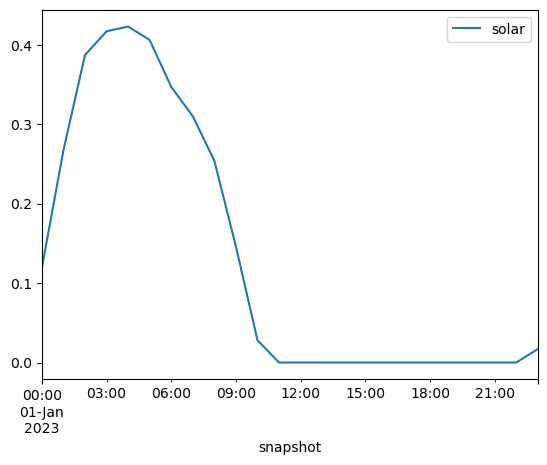

In [5]:
res_profiles.plot()

### Step 2: Construct PyPSA model

In [6]:
# create network class
network = pypsa.Network()

# define our hourly timesteps (referred to as snapshots)
network.set_snapshots(demand.index)

# define the singapore bus (i.e., the balancing zone)
network.add(
    "Bus",  # PyPSA component
    sgp['iso'], # bus name
    x = sgp['x'], # longitude
    y = sgp['y'], # latitude
)

# setup the generation technologies (referred to as carriers) we have
network.madd(
    'Carrier', # PyPSA component
    ['gas', 'solar'], # carriers
    co2_emissions={'gas' : 0.2, 'solar' : 0}, # co2/mwh
    nice_name=['Natural Gas', 'Solar PV'], # verbose names
    color=['grey', 'yellow'], # colours for plotting
)

# define the demand curve
network.add(
        "Load", 
        sgp['name'], 
        bus=sgp['iso'], 
        p_set=demand['singapore'],
    )

# ---
# now let's add our two generators

# (1) gas
network.add(
    'Generator', # PyPSA component
    'sgp_gas', # generator name
    bus = sgp['iso'], # balancing zone
    carrier = 'gas',
    p_nom = 100, # starting capacity
    marginal_cost = 50,
    p_nom_extendable = True, # can the model build more? let's say yes in this case
)

# (2) solar
network.add(
    'Generator', # PyPSA component
    'sgp_solar', # generator name
    bus = sgp['iso'], # balancing zone
    carrier = 'solar',
    p_nom = 200, # starting capacity
    p_nom_extendable = True, # let's allow the model to build more solar
    p_max_pu=res_profiles['solar'], # here's where we feed in our solar profile
    marginal_cost = 0,
    capital_cost = 5,
)

That's it! We've setup the super simple model 🎉 Let's take a look at our work...

In [7]:
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
SGP,1.0,,103.851959,1.29027,AC,,1.0,0.0,inf,PQ,,


In [8]:
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00', '2023-01-01 21:00:00',
               '2023-01-01 22:00:00', '2023-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)

In [9]:
network.loads_t.p_set

Load,Singapore
snapshot,
2023-01-01 00:00:00,283.0
2023-01-01 01:00:00,222.0
2023-01-01 02:00:00,264.0
2023-01-01 03:00:00,383.0
2023-01-01 04:00:00,243.0
2023-01-01 05:00:00,182.0
2023-01-01 06:00:00,117.0
2023-01-01 07:00:00,285.0
2023-01-01 08:00:00,306.0


### Step (3): Run optimisation (i.e., let's solve the model)

In [10]:
network.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.solvers:Log file at /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 51 primals, 122 duals
Objective: 2.17e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
12 rows, 3 cols, 14 nonzeros
2 rows, 3 cols, 4 nonzeros
Presolve : Reductions: rows 2(-120); columns 3(-48); elements 4(-178)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          2     2.1703991597e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  2.1703991597e+05
HiGHS run time      :          0.00


('ok', 'optimal')

### Step (4): Explore our results

<Axes: xlabel='snapshot'>

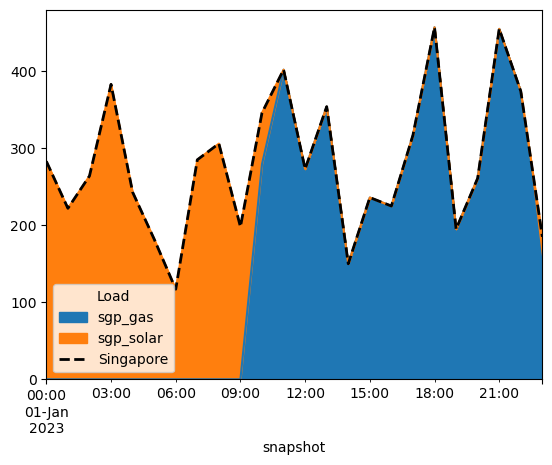

In [11]:
# let's look at the dispatch as a time series
f,ax = plt.subplots(nrows=1,ncols=1)

# dispatch by carrier
network.generators_t.p.plot.area(stacked=True,ax=ax)

# demand
network.loads_t.p.plot(color='black',linewidth=2,linestyle='--',ax=ax,label='Demand')

We can also get several statistics directly from PyPSA. Let's explore these:

In [12]:
# total dispatch by carrier
network.statistics.dispatch()

component  carrier    
Load       -             -6713.000000
Generator  Natural Gas    4122.983193
           Solar PV       2590.016807
dtype: float64

In [13]:
# total curtailment by carrier
network.statistics.curtailment()

component  carrier    
Generator  Natural Gas       0.000000
           Solar PV       4832.193277
dtype: float64

In [14]:
# energy balance by carrier and loads (i.e. input vs output)
network.statistics.energy_balance()

component  carrier      bus_carrier
Load       -            AC            -6713.000000
Generator  Natural Gas  AC             4122.983193
           Solar PV     AC             2590.016807
dtype: float64

In [15]:
# capacity expansion
network.statistics.expanded_capacity()

component  carrier    
Generator  Natural Gas     357.000000
           Solar PV       2178.151261
dtype: float64